In [42]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
%matplotlib qt

In [43]:
from util import pickler as PIC
from params import PerlinConfig
cfg = PerlinConfig()

2022-08-11 18:12:24,038 - __post_init__: Configuration:
Rows: 70
Landscape: Landscape(mode='Perlin_uniform', stdE=5.0, stdI=5.0, connection_probability=0.2, shift=1.0, params={'size': 4, 'base': 1}, seed=0)


In [44]:
def load_coordinates_and_rate(cfg):
    from custom_class import Population
    pop = Population(cfg)
    
    rate = PIC.load_rate(cfg.baseline_tag, sub_directory=cfg.sub_dir, config=cfg, skip_warmup=True)
    
    return pop.coordinates[:pop.exc_neurons.size], rate[:pop.exc_neurons.size]

In [45]:
def _plot_cluster(data:np.ndarray):
    plt.figure(figsize=(8, 8))
    ax = plt.axes(projection="3d")
    ax.set_xlabel("time")
    ax.set_ylabel("X-Position")
    ax.set_zlabel("Y-Position")

    ax.scatter(*data.T, marker=".")
    plt.legend()

In [46]:
def binarize_rate(rate:np.ndarray, threshold:float=0.5):
    # Every activation above threshold is turned to a 1, 0 otherwise.
    rate[rate >= threshold] = 1
    rate[rate < threshold] = 0
    return rate

In [47]:
coordinates, rate = load_coordinates_and_rate(cfg)
bin_rate = binarize_rate(rate.T)

2022-08-11 18:12:24,738 - __init__: Create new Population…
2022-08-11 18:12:24,749 - load: Load connectivity matrix from connectivity_matrix_Perlin_uniform_70.bn…


In [48]:
bin_rate.shape

(5000, 4900)

In [49]:
total_spikes = np.count_nonzero(bin_rate)
spike_train = np.zeros((3, total_spikes), dtype=int)
spike_train.shape

(3, 408545)

In [56]:
start = end = 0
print(f"Full shape {bin_rate.shape}")
print(f"Iter through {bin_rate.shape[1]}")
for t in range(bin_rate.shape[0]):
    S_t = bin_rate[t, :].nonzero()[0]
    spikes = S_t.size
    
    end += spikes
    spike_train[:, start:end] = np.vstack([np.full(fill_value=t, shape=spikes), coordinates[S_t].T])
    start += spikes
_plot_cluster(spike_train.T)

Full shape (5000, 4900)
Iter through 4900
2022-08-11 18:16:07,238 - _parse_legend_args: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


# Continue here

In [9]:
from analysis import DBScan

Start: Preparing figure of the connectivity distribution
2022-08-11 17:10:01,743 - __post_init__: Configuration:
Rows: 40
Landscape: Landscape(mode='Perlin_uniform', stdE=2.0, stdI=3.0, connection_probability=1.0, shift=0.5, params={'size': 2, 'base': 3}, seed=None)
2022-08-11 17:10:01,743 - __post_init__: Configuration:
Rows: 70
Landscape: Landscape(mode='Perlin_uniform', stdE=5.0, stdI=5.0, connection_probability=0.2, shift=1.0, params={'size': 4, 'base': 1}, seed=0)


In [10]:
dbscan = DBScan()

In [4]:
side = 8
x, y = np.meshgrid(np.arange(side), np.arange(side))
coordinates = np.vstack([x.ravel(), y.ravel()])

In [5]:
time_steps = 4 if side == 4 else 7
activity = np.zeros(shape=(time_steps, side**2))

In [6]:
beta = 2
if side == 4:
    activity[0, [4, 5, 8, 9, 3]] = beta
    activity[1, [5, 6, 9, 10]] = beta
    activity[2, [6, 14, 10, 11]] = beta
    activity[3, [10, 11, 14, 15]] = beta
elif side == 8:
    activity[0, [0, 1, 8, 9, 45, 46, 53, 23]] = beta
    activity[1, [1, 2, 9, 10, 44, 45, 53, 48]] = beta
    activity[2, [2, 3, 9, 11, 43, 44, 53, 52, 24]] = beta
    activity[3, [3, 4, 5, 11, 12, 35, 36, 43, 44]] = beta
    activity[4, [60, 61, 4, 5, 34, 35, 42, 43]] = beta
    activity[5, [61, 62, 5, 6, 26, 27, 34, 35]] = beta
    activity[6, [62, 63, 6, 7, 25, 26, 33, 34, 56]] = beta

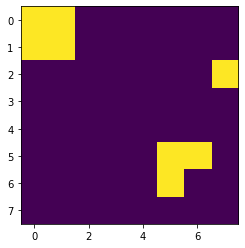

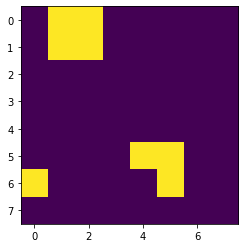

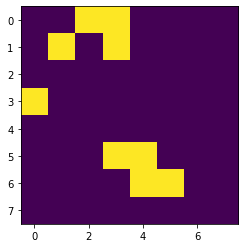

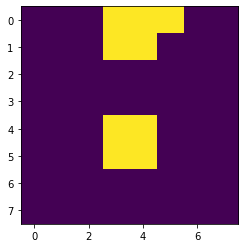

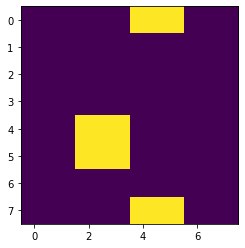

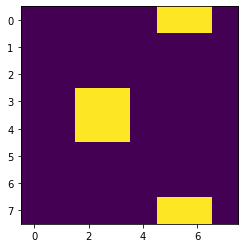

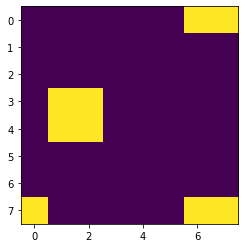

In [7]:
for a in activity:
    plt.figure()
    plt.imshow(a.reshape((side, side)))

In [8]:
activity.shape

(7, 64)

In [9]:
#data = coordinates, timepoint
data = []
for t in range(time_steps):
    #print(f"Timestep: {t}")
    active_neurons = activity[t].nonzero()[0]
    #print(f"Active Neurons (ID): {active_neurons}")
    #print(f"Coordinates: {coordinates.T[active_neurons]}")
    mix = np.vstack([*coordinates.T[active_neurons].T, np.full(shape=active_neurons.size, fill_value=t)])
    data.extend(mix.T)
data = np.asarray(data)

In [10]:
seq = cluster.DBSCAN(eps=1.5, min_samples=4)
seq.fit(data)

DBSCAN(eps=1.5, min_samples=4)

In [11]:
def scatter3D(data:np.ndarray, colors:np.ndarray=None):
    plt.figure(figsize=(8, 8))
    ax = plt.axes(projection="3d")
    sc = ax.scatter(*data.T, c=colors)
    plt.colorbar(sc)

In [12]:
def remove_noise(bin_rates, labels):
    return bin_rates[labels >= 0], labels[labels >= 0]

In [14]:
#scatter3D(data)
d, l = remove_noise(data, seq.labels_)
d.shape
#scatter3D(*remove_noise(data, seq.labels_))

(55, 3)

In [73]:
def dbscan(rate:np.ndarray, coordinates:np.ndarray):
    #data = coordinates, timepoint
    data = []
    for t in range(rate.shape[0]):
        active_neurons = rate[t].nonzero()[0]
        #print(active_neurons)
        mix = np.vstack([*coordinates[active_neurons].T, np.full(shape=active_neurons.size, fill_value=t)])
        #print(mix)
        data.extend(mix.T)
    return np.asarray(data)

In [74]:
coordinates.shape

(2, 64)

In [75]:
coordinates, rate = load_coordinates_and_rate(cfg)
bin_rate = binarize_rate(rate)

2022-07-15 18:19:14,991 - Create new Population…
2022-07-15 18:19:15,006 - Load connectivity matrix from connectivity_matrix_Perlin_uniform_70.bn…


In [76]:
data = dbscan(bin_rate.T, coordinates)

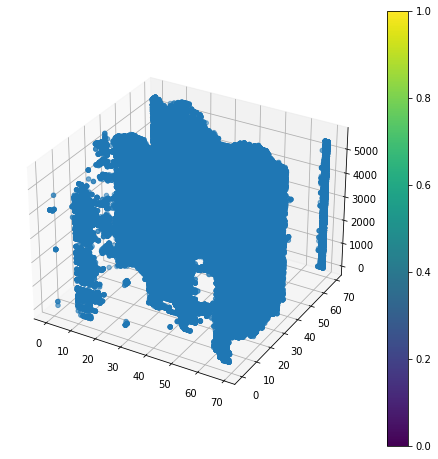

In [77]:
scatter3D(data)

In [78]:
sequence_scan = cluster.DBSCAN(eps=5., min_samples=20)
sequence_scan.fit(data)


DBSCAN(eps=5.0, min_samples=20)

In [79]:
n_clusters_ = len(set(sequence_scan.labels_)) - (1 if -1 in sequence_scan.labels_ else 0)
print(n_clusters_)

367


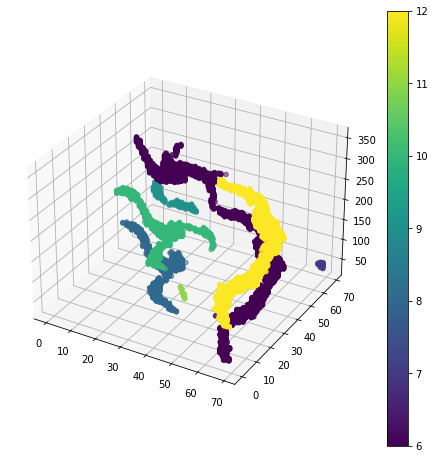

In [80]:
t = np.where((sequence_scan.labels_ >= 6) & (sequence_scan.labels_ <= 12))[0]
scatter3D(*remove_noise(data[t], sequence_scan.labels_[t]))

In [38]:
remove_noise(data[t], sequence_scan.labels_[t])

(array([[ 69,  69,  32],
        [ 68,  69,  33],
        [ 69,  69,  33],
        ...,
        [ 11,  38, 349],
        [ 11,  38, 350],
        [ 11,  38, 351]]),
 array([7, 7, 7, ..., 6, 6, 6]))